In [2]:
import numpy as np
import pandas as pd

import os

os.chdir('C:/Users/emigi/OneDrive/Desktop/Dissertation/Analysis Files/NLP Part')

british_tweets = pd.read_excel('copy tweets df.xlsx')

In [3]:
## 305867 tweets in the original dataset
## formatting: deleting tweets with no addressee

british_tweets = british_tweets.dropna(subset=['addressee'])

## Getting an idea of the range of dates

date = british_tweets.date

import statistics
         
print("Less recent tweet in dataset")
print(min(date))

print("Most recent tweet in dataset")
print(max(date))

print("Most frequent tweet in dataset")
print(statistics.mode(date))

## The general election was held on thursday 12th December, so it makes sense

Less recent tweet in dataset
2019-11-16
Most recent tweet in dataset
2019-12-14
Most frequent tweet in dataset
2019-12-12


In [4]:
from tqdm import tqdm
import re
import math
import operator
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score
import nltk

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, GRU, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.layers import Input, Embedding, Dense, Conv2D, MaxPool2D, concatenate
from keras.layers import Reshape, Flatten, Concatenate, Dropout, SpatialDropout1D, merge, Masking,TimeDistributed
from keras.optimizers import Adam
from keras.models import Model
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.layers import concatenate
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

Using TensorFlow backend.


In [5]:
## Isolating the tweets not classified and run the first iteration

classif_british_tweets = british_tweets.dropna(subset=['Sentiment'])

## Importing 4 different word embeddings and see their word coverage

def load_embed(file):
    def get_coefs(word,*arr): 
        return word, np.asarray(arr, dtype='float32')
    
    if file == '../input/embeddings/wiki-news-300d-1M/wiki-news-300d-1M.vec':
        embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(file) if len(o)>100)
    else:
        embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(file, encoding='latin'))
        
    return embeddings_index

glove_path = 'D:/Petrologica Ltd/Work Files/Word Embeddings/glove.840B.300d/glove.840B.300d.txt'
google_news_path ='D:/Petrologica Ltd/Work Files/Word Embeddings/GoogleNews-vectors-negative300/GoogleNews-vectors-negative300.bin' 
wiki_news_path = 'D:/Petrologica Ltd/Work Files/Word Embeddings/wiki-news-300d-1M/wiki-news-300d-1M.vec'
paragram_path = 'D:/Petrologica Ltd/Work Files/Word Embeddings/paragram_300_sl999/paragram_300_sl999.txt'

In [6]:
embed_google = KeyedVectors.load_word2vec_format(google_news_path, binary=True)
print('Embed google loaded.')
embed_glove = load_embed(glove_path)
#embed_google = load_embed(google_news_path)
print('Embed glove loaded.')
embed_wiki = load_embed(wiki_news_path)
print('Embed wiki loaded.')
embed_paragram = load_embed(paragram_path)
print('Embed paragram loaded')

Embed google loaded.
Embed glove loaded.
Embed wiki loaded.
Embed paragram loaded


In [7]:
def check_coverage(embedding, vocab):
    known_words = {}
    unknown_words = {}
    number_known_words = 0
    number_unknown_words = 0
    if embedding == embed_google:
        for word in tqdm(vocab):
            try:
                known_words[word] = embedding[word]
                number_known_words += vocab[word]
            except:
                unknown_words[word] = vocab[word]
                number_unknown_words += vocab[word]
        print(f"Percentage of embeddings for Vocab is: {(len(known_words)/len(vocab))*100}%")
        print(f"Percentage of embeddings for Text is: {(number_known_words/(number_known_words + number_unknown_words))*100}%")
    else:
        for word in tqdm(vocab.keys()):
            try:
                known_words[word] = embedding[word]
                number_known_words += vocab[word]
            except:
                unknown_words[word] = vocab[word]
                number_unknown_words += vocab[word]
        print(f"Percentage of embeddings for Vocab is: {(len(known_words)/len(vocab))*100}%")
        print(f"Percentage of embeddings for Text is: {(number_known_words/(number_known_words + number_unknown_words))*100}%")

    unknown_words = sorted(unknown_words.items(), key=operator.itemgetter(1))[::-1]
    
    return unknown_words

In [8]:
## Creating a vocabulary of the words in the tweets and checking coverage
from tqdm.notebook import tqdm
tqdm.pandas()

def create_vocabulary(sentences):
    vocab = {}
    for sentence in tqdm(sentences):
        for word in sentence:
            try:
                vocab[word] += 1
            except:
                vocab[word] = 1
    return vocab

text = british_tweets['text'].progress_apply(lambda x: x.split()).values
vocab = create_vocabulary(text)

C:\Users\emigi\Anaconda3\lib\site-packages\tqdm\std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [9]:
## Checking coverage
print('Checking coverage for Google.')
unknown_words_google = check_coverage(embed_google, vocab)
print('Checking coverage for Glove.')
unknown_words_glove = check_coverage(embed_glove, vocab)
print('Checking coverage for Wiki.')
unknown_words_wiki = check_coverage(embed_wiki, vocab)
print('Checking coverage for Paragram.')
unknown_words_para = check_coverage(embed_paragram, vocab)

Checking coverage for Google.



Percentage of embeddings for Vocab is: 19.556996691716144%
Percentage of embeddings for Text is: 67.6896185503142%
Checking coverage for Glove.



Percentage of embeddings for Vocab is: 23.770129044979516%
Percentage of embeddings for Text is: 78.14391965201771%
Checking coverage for Wiki.



Percentage of embeddings for Vocab is: 23.22941086256381%
Percentage of embeddings for Text is: 77.7551875562024%
Checking coverage for Paragram.



Percentage of embeddings for Vocab is: 15.378480818526388%
Percentage of embeddings for Text is: 66.31186087701414%


In [10]:
## Glove seems to be the best here. However, only 23% of vocabulary coverage. Let's 
## investigate by printing out the unknown words

unknown_words_glove[:300]

[('@BorisJohnson', 126040),
 ('@jeremycorbyn', 41643),
 ('@JamesCleverly', 10881),
 ('Brexit', 9198),
 ('@Conservatives', 9043),
 ('@JohnnyMercerUK', 6162),
 ('@UKLabour', 5633),
 ('@CarolineLucas', 5515),
 ('don’t', 3716),
 ('@ARMilani_', 3545),
 ('it’s', 2449),
 ('I’m', 2330),
 ('@DawnButlerBrent', 2240),
 ('brexit', 2200),
 ('@SamGyimah', 2185),
 ('you’re', 1973),
 ('#GE2019', 1902),
 ('@LibDems', 1869),
 ('It’s', 1827),
 ('can’t', 1705),
 ("Let's", 1536),
 ('@afneil', 1515),
 ("You're", 1511),
 ('@georgegalloway', 1488),
 ("won't", 1482),
 ('@bendepear', 1467),
 ('@trussliz', 1450),
 ('#ReleaseTheRussiaReport', 1439),
 ('Let’s', 1388),
 ("you've", 1341),
 ('😂', 1317),
 ('won’t', 1276),
 ('you’ve', 1243),
 ('You’re', 1221),
 ('#VoteLabour', 1220),
 ('#LiarJohnson', 1169),
 ('didn’t', 1161),
 ('👍', 1148),
 ('Boris.', 1129),
 ('you?', 1103),
 ('🌹', 1094),
 ('@thismorning', 1085),
 ('Brexit.', 1044),
 ('Boris,', 1026),
 ('#Brexit', 999),
 ("That's", 998),
 ('Don’t', 991),
 ("You've", 9

In [11]:
## Contractions,hashtags and emoticons are not covered
## Tags can be ingored since they are already expressed in the addressee section
## Let's deal first with hashtags

unknown_hashtags = []

for unk in unknown_words_glove:
    if '#' in unk[0]:
        unknown_hashtags.append(unk[0])
    else:
        pass

print(len(unknown_hashtags))
unknown_hashtags

11958


['#GE2019',
 '#ReleaseTheRussiaReport',
 '#VoteLabour',
 '#LiarJohnson',
 '#Brexit',
 '#NeverCorbyn',
 '#GeneralElection2019',
 '#ToriesOut',
 '#GetBrexitDone',
 '#BackBoris',
 '#GTTO',
 '#GetJohnsonGone',
 '#VoteConservative',
 '#VoteTactically',
 '#StopBrexit',
 '#GetTheToriesOut',
 '#JC4PM',
 '#GeneralElection19',
 '#ToryLies',
 '#Labour',
 '#GetBrexitGone',
 '#ChickenJohnson',
 '#BorisTheLiar',
 '#VoteLabourDecember12',
 '#VoteLabourToday',
 '#BorisJohnson',
 '#VoteLabour2019',
 '#GetBorisGone',
 '#GE19',
 '#BorisJohnsonLies',
 '#BorisTheCoward',
 '#VoteLabourDecember12th',
 '#ITVDebate',
 '#Conservatives',
 '#SaveOurNHS',
 '#ReleaseTheRussianReport',
 '#ToriesOutDecember12',
 '#VoteLabourOnThursday',
 '#brexit',
 '#GetJohnsonOut',
 '#LeadersDebate',
 '#NeverLabour',
 '#NotMyPM',
 '#VoteTheToriesOut',
 '#NOTMYPM',
 '#LabourLies',
 '#GeneralElection',
 '#DitchTheTories',
 '#VoteConservative2019',
 '#Tories',
 '#ToriesOutDecember2019',
 '#ForTheManyNotTheFew',
 '#JC4PM2019',
 '#Peopl

In [12]:
## try to strip '#' and get the tokens
from wordsegment import load, segment
load()
ex_1 = unknown_hashtags[1].replace('#','')
segment(ex_1)

['release', 'the', 'russia', 'report']

In [13]:
## Applying such wonderful and lifesaving library to my corpus
hashtags_mapping = {}
for unk in unknown_hashtags:
    unk_no_hash = unk.replace('#','')
    hashtags_mapping[unk] = segment(unk_no_hash)
hashtags_mapping

{'#GE2019': ['ge2019'],
 '#ReleaseTheRussiaReport': ['release', 'the', 'russia', 'report'],
 '#VoteLabour': ['vote', 'labour'],
 '#LiarJohnson': ['liar', 'johnson'],
 '#Brexit': ['br', 'exit'],
 '#NeverCorbyn': ['never', 'corbyn'],
 '#GeneralElection2019': ['general', 'election', '2019'],
 '#ToriesOut': ['tories', 'out'],
 '#GetBrexitDone': ['get', 'br', 'exit', 'done'],
 '#BackBoris': ['back', 'boris'],
 '#GTTO': ['gt', 'to'],
 '#GetJohnsonGone': ['get', 'johnson', 'gone'],
 '#VoteConservative': ['vote', 'conservative'],
 '#VoteTactically': ['vote', 'tactically'],
 '#StopBrexit': ['stop', 'br', 'exit'],
 '#GetTheToriesOut': ['get', 'the', 'tories', 'out'],
 '#JC4PM': ['jc4pm'],
 '#GeneralElection19': ['general', 'election', '19'],
 '#ToryLies': ['tory', 'lies'],
 '#Labour': ['labour'],
 '#GetBrexitGone': ['get', 'br', 'exit', 'gone'],
 '#ChickenJohnson': ['chicken', 'johnson'],
 '#BorisTheLiar': ['boris', 'the', 'liar'],
 '#VoteLabourDecember12': ['vote', 'labour', 'december', '12'],


In [14]:
## Let's try the same procedure for tags
unknown_tags = []

for unk in unknown_words_glove:
    if '@' in unk[0]:
        unknown_tags.append(unk[0])
    else:
        pass

print(len(unknown_tags))
unknown_tags

15355


['@BorisJohnson',
 '@jeremycorbyn',
 '@JamesCleverly',
 '@Conservatives',
 '@JohnnyMercerUK',
 '@UKLabour',
 '@CarolineLucas',
 '@ARMilani_',
 '@DawnButlerBrent',
 '@SamGyimah',
 '@LibDems',
 '@afneil',
 '@georgegalloway',
 '@bendepear',
 '@trussliz',
 '@thismorning',
 '@drdavidbull',
 '@brexitparty_uk',
 '@CCHQPress',
 '@emmadentcoad',
 '@patel4witham',
 '@snb19692',
 '@TheGreenParty',
 '@michaelgove',
 '@stellacreasy',
 '@theresa_may',
 '@MattHancock',
 '@AlanJackGraves',
 '@theSNP',
 '@robertlargan',
 '@YosefDavid9',
 '@IanMurrayMP',
 '@charlotte2153',
 '@Jeremy_Hunt',
 '@Carra23',
 '@joswinson',
 '@StanleyPJohnson',
 '@WendyMaisey',
 '@west_brom',
 '@jon_bartley',
 '@BrexitDoyin',
 '@sajidjavid',
 '@JulieAnnmaugha2',
 '@ladyastorstatue',
 '@johnmcdonnellMP',
 '@Helen_Whately',
 '@DerbyChrisW',
 '@DominicRaab',
 '@EmmaLewellBuck',
 '@CountBinface',
 '@SuellaBraverman',
 '@Channel4News',
 '@Nigel_Farage',
 '@MayaGoodfellow',
 '@JoshuaGarfield',
 '@GavinWilliamson',
 '@PaulJSweeney',


In [15]:
tags_mapping = {}
for unk in unknown_tags:
    unk_formatted = unk.replace('@','')
    tags_mapping[unk] = segment(unk_formatted)
tags_mapping

{'@BorisJohnson': ['boris', 'johnson'],
 '@jeremycorbyn': ['jeremy', 'corbyn'],
 '@JamesCleverly': ['james', 'cleverly'],
 '@Conservatives': ['conservatives'],
 '@JohnnyMercerUK': ['johnny', 'mercer', 'uk'],
 '@UKLabour': ['uk', 'labour'],
 '@CarolineLucas': ['caroline', 'lucas'],
 '@ARMilani_': ['ar', 'milani'],
 '@DawnButlerBrent': ['dawn', 'butler', 'brent'],
 '@SamGyimah': ['sam', 'gyi', 'mah'],
 '@LibDems': ['libdems'],
 '@afneil': ['af', 'neil'],
 '@georgegalloway': ['george', 'galloway'],
 '@bendepear': ['bende', 'pear'],
 '@trussliz': ['truss', 'liz'],
 '@thismorning': ['this', 'morning'],
 '@drdavidbull': ['dr', 'david', 'bull'],
 '@brexitparty_uk': ['br', 'exit', 'party', 'uk'],
 '@CCHQPress': ['cc', 'hq', 'press'],
 '@emmadentcoad': ['emma', 'dent', 'coad'],
 '@patel4witham': ['patel4', 'with', 'am'],
 '@snb19692': ['snb19692'],
 '@TheGreenParty': ['the', 'green', 'party'],
 '@michaelgove': ['michael', 'gove'],
 '@stellacreasy': ['stella', 'creasy'],
 '@theresa_may': ['there

In [16]:
## Now let's try to check the coverage again
def handle_tags_or_hash(text, dic):
    
    for hsh in dic:
        l = dic[hsh]
        if len(l) == 1:
            text = text.replace(hsh, dic[hsh][0])
        else:
            text = text.replace(hsh, " ".join(dic[hsh]))
        
    return text

british_tweets["text"] = british_tweets["text"].progress_apply(lambda x: handle_tags_or_hash(x, hashtags_mapping))
british_tweets["text"] = british_tweets["text"].progress_apply(lambda x: handle_tags_or_hash(x, tags_mapping))

In [17]:
## Recreating the vocabulary
tweets = british_tweets["text"].progress_apply(lambda x: x.split()).values
vocab = create_vocabulary(tweets)
unknown_words_glove = check_coverage(embed_glove, vocab)


Percentage of embeddings for Vocab is: 28.47364214283059%
Percentage of embeddings for Text is: 87.58373957571538%


In [18]:
## The percentage covered is still not significant. Let's try with punctuation and symbols mapping
punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'
symbol_mapping = {"‘": "'", "₹": "$", "´": "'", "°": "degrees", "€": "$", "™": "tm", "√": " sqrt ", "×": "x", "²": "2", "—": "-", "–": "-", "’": "'", "_": "-", "`": "'", '“': '"', '”': '"', '“': '"', "£": "$", '∞': 'infinity', 'θ': 'theta', '÷': '/', 'α': 'alpha', '•': '.', 'à': 'a', '−': '-', 'β': 'beta', '∅': 'empty', '³': '3', 'π': 'pi', }

def handle_punctuation(text, symbol_mapping, punct):
    
    for symbol in symbol_mapping:
        text = text.replace(symbol, symbol_mapping[symbol])
    
    for p in punct:
        text = text.replace(p, f' {p} ')
    
    return text

In [19]:
british_tweets["text"] = british_tweets["text"].progress_apply(lambda x: handle_punctuation(x, symbol_mapping, punct))

In [20]:
## Recreating the vocabulary
tweets = british_tweets["text"].progress_apply(lambda x: x.split()).values
vocab = create_vocabulary(tweets)
unknown_words_glove = check_coverage(embed_glove, vocab)


Percentage of embeddings for Vocab is: 46.34038934612932%
Percentage of embeddings for Text is: 96.39434312284675%


In [21]:
## 39%. 10% improvement. Let us see what is still not covered
len(unknown_words_glove)

70674

In [22]:
unknown_words_glove[:100]

[('corbyn', 44292),
 ('Brexit', 11536),
 ('brexit', 2702),
 ('ge2019', 2001),
 ('realDonaldTrump', 1589),
 ('😂', 1392),
 ('👍', 1224),
 ('🌹', 1140),
 ('patel4', 745),
 ('🤔', 669),
 ('snb19692', 629),
 ('🙄', 572),
 ('BREXIT', 567),
 ('largan', 563),
 ('yosefdavid9', 553),
 ('❤️', 507),
 ('😂😂😂', 497),
 ('swinson', 492),
 ('carra23', 459),
 ('🇬🇧', 448),
 ('jc4pm', 445),
 ('maisey', 441),
 ('🤣', 418),
 ('julieannmaugha2', 393),
 ('labourToday', 373),
 ('labourDecember12', 372),
 ('labour2019', 363),
 ('✅', 355),
 ('ge19', 354),
 ('johnsonLies', 323),
 ('😂😂', 314),
 ('bbcqt', 311),
 ('labourDecember12th', 295),
 ('bbcNews', 291),
 ('😉', 275),
 ('trickett', 265),
 ('✔️', 256),
 ('🤥', 254),
 ('BRINO', 251),
 ('👍🏻', 249),
 ('outDecember12', 242),
 ('labourOnThursday', 242),
 ('🤡', 220),
 ('😡', 219),
 ('🤣🤣🤣', 213),
 ('labourLies', 212),
 ('❌', 202),
 ('😂😂😂😂', 202),
 ('👏', 196),
 ('piersmorgan', 195),
 ('😁', 192),
 ('conservative2019', 192),
 ('😊', 191),
 ('marr9', 187),
 ('suehayman1', 183),
 ('

In [23]:
## Handle accentuations, acronyms, mispelligns and capital letters
def add_upper_lower(embed, vocab):
    count_lower = 0
    count_upper = 0
    for word in vocab:
        if word in embed and word.lower() not in embed:
            embed[word.lower()] = embed[word]
            count_lower += 1
        elif word.lower() in embed and word not in embed:
            embed[word] = embed[word.lower()]
            count_upper += 1
    print(f'Added {count_lower} lowercase words to the embedding.')
    print(f'Added {count_upper} uppercase words to the embedding.')

add_upper_lower(embed_glove, vocab)

Added 1114 lowercase words to the embedding.
Added 857 uppercase words to the embedding.


In [24]:
unknown_words_glove = check_coverage(embed_glove, vocab)


Percentage of embeddings for Vocab is: 47.15279254107571%
Percentage of embeddings for Text is: 97.34674151347966%


In [25]:
'brexit' in embed_glove

False

In [26]:
## This might be a problem. However, we got 40% coverage, which is not good neither bad. We will test the performance of RNN and
## possibly look for possible fixes

## Defining initial train and test
starting_train = classif_british_tweets
final_df = british_tweets

def train_test_division(starting_train, df, division_percentage):
    n = starting_train.shape[0]
    n_test = int((n / division_percentage[0])*division_percentage[1])
    test_data = df.iloc[n:(n+n_test)+1, :]
    return (starting_train, test_data)

starting_train, starting_test = train_test_division(starting_train, final_df, (0.7, 0.3))

In [27]:
def word_embedding(df):
    
    articles = df['text']
    general_vectors_distr = []
    mem_l = []
    nb_words = 0
    iterat1 = 0
    for art in articles:
        tokens = nltk.word_tokenize(art, language='english')
        for t in tokens:
            try:
                word_vector = embed_glove[t]
                general_vectors_distr.append(word_vector)
                if t in mem_l:
                    pass
                else:
                    mem_l.append(t)
                    nb_words += 1
            except:
                pass
        # print(iterat1)
        iterat1 += 1
    
    #print(general_vectors_distr)
      
    all_embs = np.stack(general_vectors_distr)  
    emb_mean, emb_std = all_embs.mean(), all_embs.std()    
    embed_size = all_embs.shape[1]
    
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    ## filling the embedding matrix
    iterat2 = 0
    for token, i in zip(mem_l, range(nb_words)):
        embedding_matrix[i] = embed_glove[token]
        # print(iterat2)
        iterat2 += 1
    
    return embedding_matrix

In [28]:
embed_size = 300 # how big is each word vector
max_features = 3320 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 20 # max number of words in a tweet to use

In [29]:
## To input into the neural network, we must first tokenize the sentences
starting_train_X = starting_train['text']
starting_test_X = starting_test['text']
starting_train_Y = starting_train['Sentiment']
starting_test_Y = starting_test['Sentiment']

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(starting_train_X))
train_X = tokenizer.texts_to_sequences(starting_train_X)

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(starting_test_X))
test_X = tokenizer.texts_to_sequences(starting_test_X)

## Pad the sequences
train_X = pad_sequences(train_X, maxlen=maxlen)
test_X = pad_sequences(test_X, maxlen=maxlen)

## Substituting indices greater than 3320 with 0
train_X[train_X > 3320] = 0
test_X[test_X > 3320] = 0

print(train_X.shape)
print(test_X.shape)

(871, 20)
(374, 20)


In [30]:
embedding_matrix_1 = word_embedding(starting_train)
embedding_matrix = np.mean([embedding_matrix_1], axis = 0)
np.shape(embedding_matrix)

(3320, 300)

In [31]:
class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

In [32]:
def model_bilstm_attention(embedding_matrix):
    inp = Input(shape=(maxlen,))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix], trainable=False)(inp)
    x = SpatialDropout1D(0.1)(x)
    
    l = Bidirectional(LSTM(64, return_sequences=True))(x)
    g = Bidirectional(GRU(64, return_sequences=True))(x)
    x = concatenate([l, g])
    x = Bidirectional(LSTM(64//2, return_sequences=True))(x)
    
    #x1 = Attention(maxlen)(x)
    x2 = GlobalAveragePooling1D()(x)
    x3 = GlobalMaxPooling1D()(x)
    
    x = Concatenate()([x2, x3])
    x = Dense(16, activation='relu')(x)
    x = Dropout(0.1)(x)
    outp = Dense(1, activation="sigmoid")(x)
    
    model = Model(inputs=inp, outputs=outp)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [33]:
model = model_bilstm_attention(embedding_matrix)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 20)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 20, 300)      996000      input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 20, 300)      0           embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 20, 128)      186880      spatial_dropout1d_1[0][0]        
____________________________________________________________________________________________

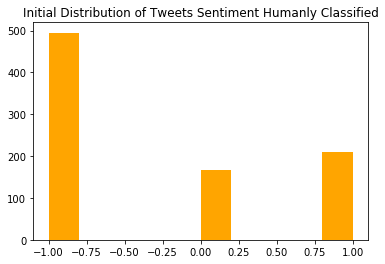

In [34]:
## Looking at the distribution of sentiments to set the initial weights
import matplotlib.pyplot as plt

plt.hist(starting_train_Y, color='orange')
plt.title('Initial Distribution of Tweets Sentiment Humanly Classified')
plt.savefig('Initial Distribution of Tweets Sentiment Humanly Classified.png')

In [35]:
## Formatting the label to fit the model
from keras.utils import to_categorical

## converting the bad sentiment (i.e. -1, to 2)

starting_train_Y[starting_train_Y == -1] = 2

train_Y = to_categorical(starting_train_Y)

C:\Users\emigi\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\emigi\Anaconda3\lib\site-packages\pandas\core\generic.py:8766: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [36]:
## Conversely to the italian articles, here we have a majority of negative tweets
class_weight = {0 : 0.8,
                1 : 1.2}

## First trial, 20 epochs
res_pred = model.fit(train_X, train_Y[:,0], validation_split=0.2, epochs=20, class_weight = class_weight)

Train on 696 samples, validate on 175 samples
Epoch 1/20
696/696 [==============================] - 4s 5ms/step - loss: 0.4893 - accuracy: 0.8046 - val_loss: 0.6261 - val_accuracy: 0.7429
Epoch 2/20
696/696 [==============================] - 1s 780us/step - loss: 0.4649 - accuracy: 0.8247 - val_loss: 0.5679 - val_accuracy: 0.7429
Epoch 3/20
696/696 [==============================] - 1s 739us/step - loss: 0.4543 - accuracy: 0.8161 - val_loss: 0.5875 - val_accuracy: 0.7429
Epoch 4/20
696/696 [==============================] - 1s 761us/step - loss: 0.4129 - accuracy: 0.8261 - val_loss: 0.5348 - val_accuracy: 0.7086
Epoch 5/20
696/696 [==============================] - 1s 805us/step - loss: 0.3737 - accuracy: 0.8405 - val_loss: 0.6272 - val_accuracy: 0.7086
Epoch 6/20
696/696 [==============================] - 1s 744us/step - loss: 0.3008 - accuracy: 0.8851 - val_loss: 0.6442 - val_accuracy: 0.6914
Epoch 7/20
696/696 [==============================] - 1s 800us/step - loss: 0.2557 - accurac

In [37]:
## Predicting the first test. The accuracy seems really good
pred_test_x = model.predict(test_X)

In [38]:
## In the case of positives, it is convenient to adopt other weights. 10 epochs to try avoiding overfitting
class_weight_positives = {0 : 1.0,
                    1 : 2.9}


res_pred_pos = model.fit(train_X, train_Y[:, 1], validation_split=0.2, epochs=10, class_weight = class_weight_positives)
pred_test_x_ones = model.predict(test_X)

Train on 696 samples, validate on 175 samples
Epoch 1/10
696/696 [==============================] - 1s 818us/step - loss: 1.7564 - accuracy: 0.4971 - val_loss: 1.0732 - val_accuracy: 0.5029
Epoch 2/10
696/696 [==============================] - 1s 857us/step - loss: 0.9973 - accuracy: 0.7040 - val_loss: 1.0716 - val_accuracy: 0.7200
Epoch 3/10
696/696 [==============================] - 1s 758us/step - loss: 0.9894 - accuracy: 0.7672 - val_loss: 1.0766 - val_accuracy: 0.6629
Epoch 4/10
696/696 [==============================] - 1s 792us/step - loss: 0.9881 - accuracy: 0.6853 - val_loss: 1.0736 - val_accuracy: 0.5600
Epoch 5/10
696/696 [==============================] - 1s 951us/step - loss: 0.9820 - accuracy: 0.7011 - val_loss: 1.0894 - val_accuracy: 0.6914
Epoch 6/10
696/696 [==============================] - 1s 805us/step - loss: 0.9656 - accuracy: 0.7083 - val_loss: 1.1197 - val_accuracy: 0.6971
Epoch 7/10
696/696 [==============================] - 1s 812us/step - loss: 0.9225 - accur

In [39]:
## Same for negatives
class_weight_negatives = {0 : 1.2,
                          1 : 0.8}


res_pred_neg = model.fit(train_X, train_Y[:, 2], validation_split=0.2, epochs=15, class_weight = class_weight_negatives)
pred_test_x_neg = model.predict(test_X)

Train on 696 samples, validate on 175 samples
Epoch 1/15
696/696 [==============================] - 1s 854us/step - loss: 0.8908 - accuracy: 0.4871 - val_loss: 0.7280 - val_accuracy: 0.5200
Epoch 2/15
696/696 [==============================] - 1s 790us/step - loss: 0.6587 - accuracy: 0.5704 - val_loss: 0.6958 - val_accuracy: 0.5143
Epoch 3/15
696/696 [==============================] - 1s 805us/step - loss: 0.6236 - accuracy: 0.6178 - val_loss: 0.7108 - val_accuracy: 0.5200
Epoch 4/15
696/696 [==============================] - 1s 805us/step - loss: 0.5789 - accuracy: 0.7069 - val_loss: 0.7034 - val_accuracy: 0.5886
Epoch 5/15
696/696 [==============================] - 1s 755us/step - loss: 0.5147 - accuracy: 0.7342 - val_loss: 0.7857 - val_accuracy: 0.5371
Epoch 6/15
696/696 [==============================] - 1s 755us/step - loss: 0.4317 - accuracy: 0.8218 - val_loss: 0.8779 - val_accuracy: 0.5143
Epoch 7/15
696/696 [==============================] - 0s 685us/step - loss: 0.3826 - accur

In [40]:
acc_pred = res_pred.history['accuracy'][-1]
test_acc_pred = res_pred.history['val_accuracy'][-1]

acc_pos_pred = res_pred_pos.history['accuracy'][-1]
test_acc_pos_pred = res_pred_pos.history['val_accuracy'][-1]

acc_neg_pred = res_pred_neg.history['accuracy'][-1]
test_acc_neg_pred = res_pred_neg.history['val_accuracy'][-1]

In [41]:
## Rounding on starting_test
## Output in probabilistic form, rounding the variables if p>=0.5 to 1, opposite to 0
pred_test_X_round = np.round(pred_test_x, decimals=0)
pred_test_X_ones_round = np.round(pred_test_x_ones, decimals=0)
pred_test_X_negatives_round = np.round(pred_test_x_neg, decimals=0)

In [42]:
## Starting the iteration for at least 200000 tweets.
## From there on the remaining ones will be predicted normally

test_pred_Y = np.hstack((pred_test_X_round, pred_test_X_ones_round, pred_test_X_negatives_round))

starting_df_Y = np.vstack((train_Y, test_pred_Y))
print(train_Y.shape)
print(starting_df_Y.shape)
print(starting_train.shape[0])

(871, 3)
(1245, 3)
871


In [43]:
## Possible problems of overfitting here. TO DO: Find ways to deal with them.
## I reduced the number of epochs.
## Initiating the iterative procedure

## getting last_index and setting the first parameters for the iteration

last_ind = starting_train.shape[0] + starting_test.shape[0]
iterat = 0
df_Y_i = starting_df_Y
starting_df_iterat = final_df.iloc[:last_ind, :]
accuracy_l = []
accuracy_ones_l = []
accuracy_negatives_l = []
validation_l = []
validation_ones_l = []
validation_negatives_l = []
n = 0
print(starting_df_iterat.shape[0])

1245


In [44]:
## Iteration Algorithm for the RNN
import time

while n < 170000:
    
    starting_train_iterat, starting_test_iterat = train_test_division(starting_df_iterat, final_df, (0.7, 0.3))
    
    df_iterat = pd.concat([starting_train_iterat, starting_test_iterat])
    n = df_iterat.shape[0]
    
#    if n >= 10000:
#        print(f'Do you want to continue? ({n} articles classified)')
#        inp = input()
#        if inp == 'Y':
#            break
#        else:
#            continue
    
    try:
        word_embedding_df_i = word_embedding(pd.concat([starting_train_iterat, starting_test_iterat]))
    except:
        pass
    max_features = word_embedding_df_i.shape[0]
    
    starting_train_X_i = starting_train_iterat['text']
    starting_test_X_i = starting_test_iterat['text']
    
    tokenizer = Tokenizer(num_words=max_features)
    tokenizer.fit_on_texts(list(starting_train_X_i))
    train_X_i = tokenizer.texts_to_sequences(starting_train_X_i)

    tokenizer = Tokenizer(num_words=max_features)
    tokenizer.fit_on_texts(list(starting_test_X_i))
    test_X_i = tokenizer.texts_to_sequences(starting_test_X_i)
    
    print(f'df iterat initial shape : {df_iterat.shape}')
    ## Pad the sequences
    train_X_i = pad_sequences(train_X_i, maxlen=maxlen)
    print(f'Shape Train X : {train_X_i.shape}')
    test_X_i = pad_sequences(test_X_i, maxlen=maxlen)
    print(f'Shape Test X : {test_X_i.shape}')
    print(f'Shape Y : {df_Y_i.shape}')
    
    embedding_matrix = np.mean([word_embedding_df_i], axis = 0)
    
    model = model_bilstm_attention(embedding_matrix)
    
    for i in range(3):
        if i == 0:
            res_i_ones = model.fit(train_X_i, df_Y_i[:, i], validation_split=0.2, epochs=17, class_weight = class_weight)
            
            acc_i = res_i_ones.history['accuracy'][-1]
            val_i = res_i_ones.history['val_accuracy'][-1]
            accuracy_l.append(acc_i)
            validation_l.append(val_i)
            pred_test_x_i = model.predict(test_X_i)
            pred_test_X_round_i = np.round(pred_test_x_i, decimals=0)

            
            
        elif i == 1:
            res_i_pos = model.fit(train_X_i, df_Y_i[:, i], validation_split=0.2, epochs=10, class_weight = class_weight_positives)
            
            acc_i = res_i_pos.history['accuracy'][-1]
            val_i = res_i_pos.history['val_accuracy'][-1]
            accuracy_ones_l.append(acc_i)
            validation_ones_l.append(val_i)
            pred_test_x_ones_i = model.predict(test_X_i)
            pred_test_X_ones_round_i = np.round(pred_test_x_ones_i, decimals=0)

            
        elif i == 2:
            res_i_neg = model.fit(train_X_i, df_Y_i[:, i], validation_split=0.2, epochs=15, class_weight = class_weight_negatives)
            
            acc_i = res_i_neg.history['accuracy'][-1]
            val_i = res_i_neg.history['val_accuracy'][-1]
            accuracy_negatives_l.append(acc_i)
            validation_negatives_l.append(val_i)
            pred_test_x_negatives_i = model.predict(test_X_i)
            pred_test_X_negatives_round_i = np.round(pred_test_x_negatives_i, decimals=0)
    
    print(f'prevision shape : {pred_test_X_round_i.shape}')
    print(f'prevision shape ones : {pred_test_X_ones_round_i.shape}')
    print(f'prevision shape negat : {pred_test_X_negatives_round_i.shape}')
    
    test_pred_Y_i = np.hstack((pred_test_X_round_i, pred_test_X_ones_round_i, pred_test_X_negatives_round_i))
    df_Y_i = np.vstack((starting_df_Y, test_pred_Y_i))
    
    starting_df_Y = df_Y_i
    starting_df_iterat = df_iterat
    print(f'df iterat final shape : {starting_df_iterat.shape}')
    print(f'final df Y shape : {df_Y_i.shape}')
    
    iterat += 1

df iterat initial shape : (1779, 6)
Shape Train X : (1245, 20)
Shape Test X : (534, 20)
Shape Y : (1245, 3)
Train on 996 samples, validate on 249 samples
Epoch 1/17
996/996 [==============================] - 3s 3ms/step - loss: 0.5224 - accuracy: 0.8022 - val_loss: 0.5022 - val_accuracy: 0.8153
Epoch 2/17
996/996 [==============================] - 1s 733us/step - loss: 0.5007 - accuracy: 0.8153 - val_loss: 0.4925 - val_accuracy: 0.8153
Epoch 3/17
996/996 [==============================] - 1s 745us/step - loss: 0.4980 - accuracy: 0.8153 - val_loss: 0.4870 - val_accuracy: 0.8153
Epoch 4/17
996/996 [==============================] - 1s 743us/step - loss: 0.4866 - accuracy: 0.8153 - val_loss: 0.4900 - val_accuracy: 0.8153
Epoch 5/17
996/996 [==============================] - 1s 771us/step - loss: 0.4720 - accuracy: 0.8163 - val_loss: 0.4825 - val_accuracy: 0.8153
Epoch 6/17
996/996 [==============================] - 1s 715us/step - loss: 0.4483 - accuracy: 0.8343 - val_loss: 0.4896 - val_a

Epoch 5/10
2033/2033 [==============================] - 1s 723us/step - loss: 0.9092 - accuracy: 0.8028 - val_loss: 0.8370 - val_accuracy: 0.8507
Epoch 6/10
2033/2033 [==============================] - 1s 714us/step - loss: 0.8966 - accuracy: 0.8028 - val_loss: 0.8179 - val_accuracy: 0.8507
Epoch 7/10
2033/2033 [==============================] - 1s 701us/step - loss: 0.8624 - accuracy: 0.8028 - val_loss: 0.8382 - val_accuracy: 0.8507
Epoch 8/10
2033/2033 [==============================] - 1s 705us/step - loss: 0.8353 - accuracy: 0.7403 - val_loss: 0.8716 - val_accuracy: 0.5167
Epoch 9/10
2033/2033 [==============================] - 1s 697us/step - loss: 0.8084 - accuracy: 0.8047 - val_loss: 0.8631 - val_accuracy: 0.7976
Epoch 10/10
2033/2033 [==============================] - 1s 697us/step - loss: 0.7320 - accuracy: 0.8008 - val_loss: 0.8934 - val_accuracy: 0.7289
Train on 2033 samples, validate on 509 samples
Epoch 1/15
2033/2033 [==============================] - 1s 709us/step - loss

Epoch 6/15
2905/2905 [==============================] - 2s 700us/step - loss: 0.5760 - accuracy: 0.7188 - val_loss: 0.5634 - val_accuracy: 0.7221
Epoch 7/15
2905/2905 [==============================] - 2s 734us/step - loss: 0.5564 - accuracy: 0.7325 - val_loss: 0.5576 - val_accuracy: 0.7070
Epoch 8/15
2905/2905 [==============================] - 2s 704us/step - loss: 0.5322 - accuracy: 0.7501 - val_loss: 0.5684 - val_accuracy: 0.7139
Epoch 9/15
2905/2905 [==============================] - 2s 701us/step - loss: 0.5015 - accuracy: 0.7635 - val_loss: 0.5912 - val_accuracy: 0.6864
Epoch 10/15
2905/2905 [==============================] - 2s 695us/step - loss: 0.4509 - accuracy: 0.8003 - val_loss: 0.5919 - val_accuracy: 0.6946
Epoch 11/15
2905/2905 [==============================] - 2s 712us/step - loss: 0.4133 - accuracy: 0.8169 - val_loss: 0.6130 - val_accuracy: 0.6974
Epoch 12/15
2905/2905 [==============================] - 2s 702us/step - loss: 0.3533 - accuracy: 0.8496 - val_loss: 0.644

Train on 5930 samples, validate on 1483 samples
Epoch 1/17
5930/5930 [==============================] - 6s 965us/step - loss: 0.3431 - accuracy: 0.9003 - val_loss: 0.2692 - val_accuracy: 0.9346
Epoch 2/17
5930/5930 [==============================] - 4s 643us/step - loss: 0.3199 - accuracy: 0.9052 - val_loss: 0.2350 - val_accuracy: 0.9346
Epoch 3/17
5930/5930 [==============================] - 4s 665us/step - loss: 0.3132 - accuracy: 0.9052 - val_loss: 0.2372 - val_accuracy: 0.9346
Epoch 4/17
5930/5930 [==============================] - 4s 645us/step - loss: 0.2953 - accuracy: 0.9046 - val_loss: 0.2404 - val_accuracy: 0.9346
Epoch 5/17
5930/5930 [==============================] - 4s 675us/step - loss: 0.2709 - accuracy: 0.9059 - val_loss: 0.2394 - val_accuracy: 0.9265
Epoch 6/17
5930/5930 [==============================] - 4s 689us/step - loss: 0.2350 - accuracy: 0.9153 - val_loss: 0.2456 - val_accuracy: 0.9184
Epoch 7/17
5930/5930 [==============================] - 4s 711us/step - loss

Epoch 12/17
8472/8472 [==============================] - 6s 709us/step - loss: 0.0346 - accuracy: 0.9881 - val_loss: 0.5313 - val_accuracy: 0.8924
Epoch 13/17
8472/8472 [==============================] - 6s 705us/step - loss: 0.0274 - accuracy: 0.9916 - val_loss: 0.5928 - val_accuracy: 0.8919
Epoch 14/17
8472/8472 [==============================] - 6s 715us/step - loss: 0.0231 - accuracy: 0.9924 - val_loss: 0.6189 - val_accuracy: 0.9023
Epoch 15/17
8472/8472 [==============================] - 7s 794us/step - loss: 0.0199 - accuracy: 0.9933 - val_loss: 0.6511 - val_accuracy: 0.8971
Epoch 16/17
8472/8472 [==============================] - 6s 713us/step - loss: 0.0231 - accuracy: 0.9922 - val_loss: 0.6013 - val_accuracy: 0.9160
Epoch 17/17
8472/8472 [==============================] - 6s 697us/step - loss: 0.0291 - accuracy: 0.9895 - val_loss: 0.6033 - val_accuracy: 0.8952
Train on 8472 samples, validate on 2119 samples
Epoch 1/10
8472/8472 [==============================] - 6s 696us/step 

Epoch 5/15
17292/17292 [==============================] - 12s 703us/step - loss: 0.5419 - accuracy: 0.7080 - val_loss: 0.5686 - val_accuracy: 0.7387
Epoch 6/15
17292/17292 [==============================] - 13s 724us/step - loss: 0.5091 - accuracy: 0.7266 - val_loss: 0.5860 - val_accuracy: 0.7317
Epoch 7/15
17292/17292 [==============================] - 12s 719us/step - loss: 0.4685 - accuracy: 0.7546 - val_loss: 0.6125 - val_accuracy: 0.7044
Epoch 8/15
17292/17292 [==============================] - 12s 722us/step - loss: 0.4196 - accuracy: 0.7830 - val_loss: 0.6669 - val_accuracy: 0.7005
Epoch 9/15
17292/17292 [==============================] - 12s 710us/step - loss: 0.3761 - accuracy: 0.8089 - val_loss: 0.7735 - val_accuracy: 0.7081
Epoch 10/15
17292/17292 [==============================] - 12s 704us/step - loss: 0.3308 - accuracy: 0.8351 - val_loss: 0.8454 - val_accuracy: 0.7091
Epoch 11/15
17292/17292 [==============================] - 12s 696us/step - loss: 0.2920 - accuracy: 0.85

50418/50418 [==============================] - 73s 1ms/step - loss: 0.0724 - accuracy: 0.9723 - val_loss: 0.2508 - val_accuracy: 0.9497
Epoch 9/17
50418/50418 [==============================] - 73s 1ms/step - loss: 0.0570 - accuracy: 0.9787 - val_loss: 0.2591 - val_accuracy: 0.9443
Epoch 10/17
50418/50418 [==============================] - 73s 1ms/step - loss: 0.0477 - accuracy: 0.9823 - val_loss: 0.2541 - val_accuracy: 0.9422
Epoch 11/17
50418/50418 [==============================] - 73s 1ms/step - loss: 0.0408 - accuracy: 0.9841 - val_loss: 0.2778 - val_accuracy: 0.9363
Epoch 12/17
50418/50418 [==============================] - 73s 1ms/step - loss: 0.0348 - accuracy: 0.9867 - val_loss: 0.2910 - val_accuracy: 0.9396
Epoch 13/17
50418/50418 [==============================] - 73s 1ms/step - loss: 0.0333 - accuracy: 0.9874 - val_loss: 0.3156 - val_accuracy: 0.9398
Epoch 14/17
50418/50418 [==============================] - 73s 1ms/step - loss: 0.0306 - accuracy: 0.9883 - val_loss: 0.2852 

102895/102895 [==============================] - 231s 2ms/step - loss: 0.5273 - accuracy: 0.7413 - val_loss: 0.4583 - val_accuracy: 0.7758
Epoch 2/15
102895/102895 [==============================] - 231s 2ms/step - loss: 0.4904 - accuracy: 0.7565 - val_loss: 0.4474 - val_accuracy: 0.7826
Epoch 3/15
102895/102895 [==============================] - 230s 2ms/step - loss: 0.4748 - accuracy: 0.7664 - val_loss: 0.4498 - val_accuracy: 0.7856
Epoch 4/15
102895/102895 [==============================] - 231s 2ms/step - loss: 0.4541 - accuracy: 0.7774 - val_loss: 0.4503 - val_accuracy: 0.7910
Epoch 5/15
102895/102895 [==============================] - 231s 2ms/step - loss: 0.4307 - accuracy: 0.7883 - val_loss: 0.4598 - val_accuracy: 0.7800
Epoch 6/15
102895/102895 [==============================] - 230s 2ms/step - loss: 0.4072 - accuracy: 0.8000 - val_loss: 0.4836 - val_accuracy: 0.7642
Epoch 7/15
102895/102895 [==============================] - 231s 2ms/step - loss: 0.3810 - accuracy: 0.8153 - v

In [45]:
## Checking the number of iterations and adding the first to the scores

accuracy_l = [acc_pred] + accuracy_l
accuracy_ones_l = [acc_pos_pred] + accuracy_ones_l
accuracy_negatives_l = [acc_neg_pred] + accuracy_negatives_l

validation_l = [test_acc_pred] + validation_l
validation_ones_l = [test_acc_pos_pred] + validation_ones_l
validation_negatives_l = [test_acc_neg_pred] + validation_negatives_l

print(f'Number of dynamic alg. : {iterat}')

Number of dynamic alg. : 14


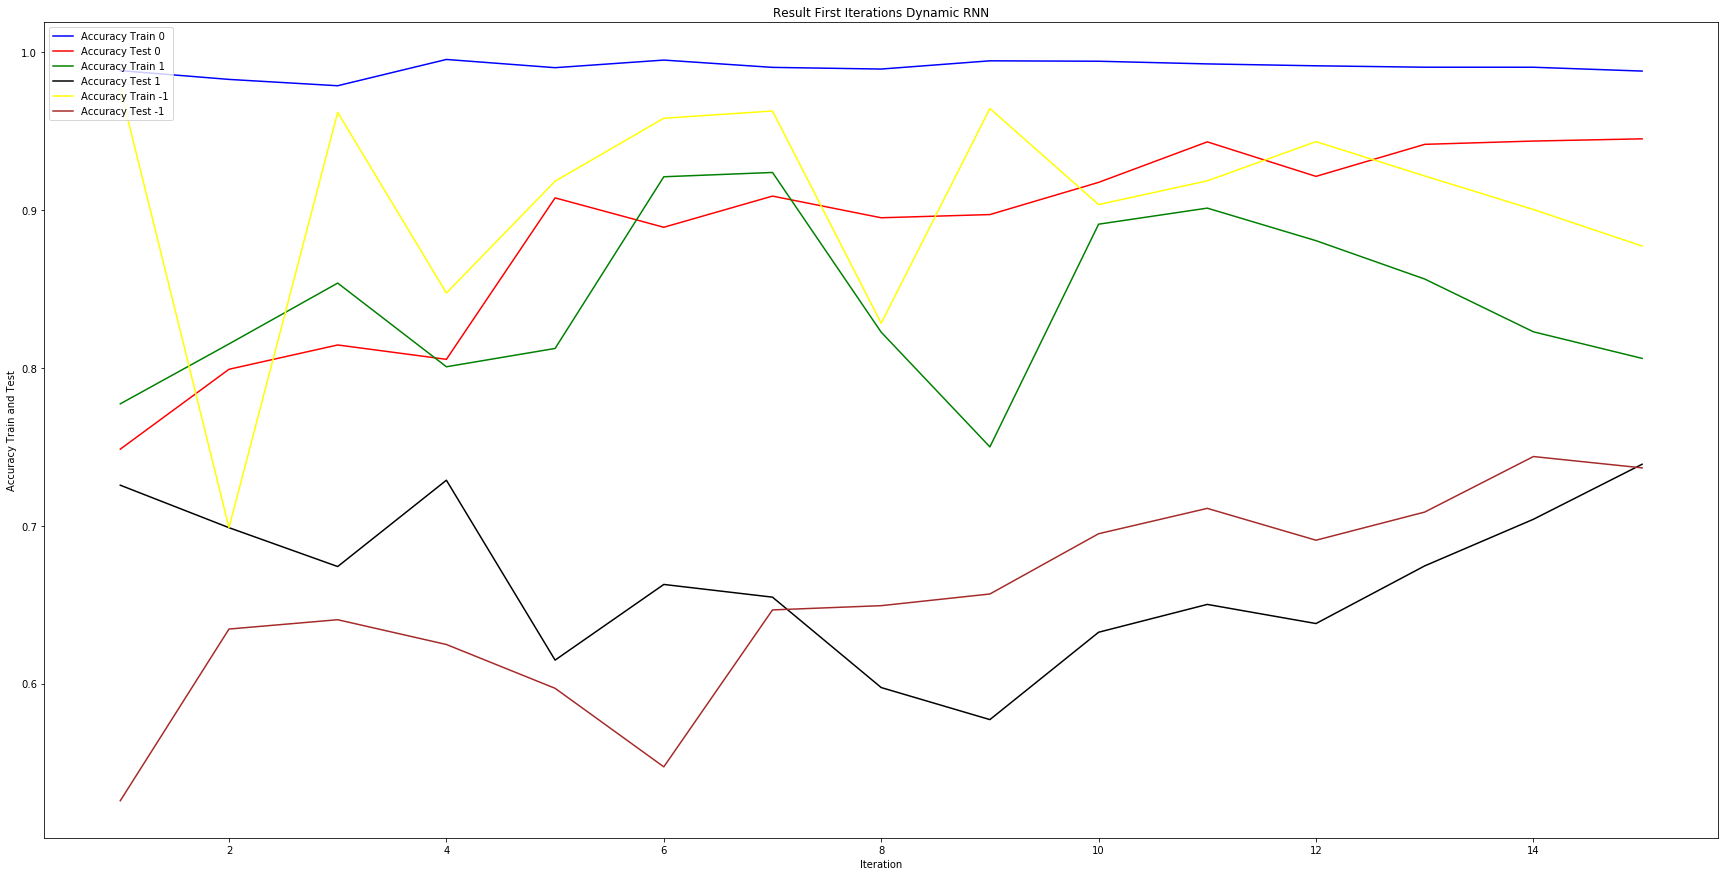

<Figure size 432x288 with 0 Axes>

In [47]:
## 13 + 1 iterations to plot. 

import matplotlib.pyplot as plt
  
iterat = list(range(1, 16))    

data = ((iterat, accuracy_l), (iterat, validation_l), (iterat, accuracy_ones_l), 
        (iterat, validation_ones_l), (iterat, accuracy_negatives_l), (iterat, validation_negatives_l))
colors = ('blue', 'red',
          'green', 'black',
          'yellow', 'brown')
groups = ('Accuracy Train 0', 'Accuracy Test 0', 'Accuracy Train 1', 'Accuracy Test 1', 'Accuracy Train -1', 'Accuracy Test -1')

fig= plt.figure(figsize=(30,15))
ax = fig.add_subplot(1, 1, 1)

for dat, color, group in zip(data, colors, groups):
    x, y = dat
    ax.plot(x, y, c=color, label=group)

plt.legend(loc=2)
plt.xlabel('Iteration')
plt.ylabel('Accuracy Train and Test')
plt.title('Result First Iterations Dynamic RNN')
plt.show()
plt.savefig('RNN British Tweets First 14 Iterations Plot.jpeg')

In [48]:
## Converting the 180000 tweets into sentiment column

sentiment = []

for y in df_Y_i:
    neutr = y[0]
    pos = y[1]
    neg = y[2]
    if neutr == 1:
        if sum([pos, neg]) < 1:
            sentiment.append(0)
        else:
            if pos == 1 and neg == 0:
                sentiment.append(1)
            elif neg == 1 and pos == 0:
                sentiment.append(-1)
            elif neg == 1 and pos == 1:
                sentiment.append(np.random.choice([-1, 1]))
    elif neutr == 0 and sum([pos, neg]) < 1:
        sentiment.append(np.random.randint(-1, 2))
    elif neutr == 0 and sum([pos, neg]) >= 1:
        if pos == 1 and neg == 0:
            sentiment.append(1)
        elif neg == 1 and pos == 0:
            sentiment.append(-1)
        elif neg == 1 and pos == 1:
                sentiment.append(np.random.choice([-1, 1]))

Text(0.5, 1.0, 'Final distribution of sentiment British tweets')

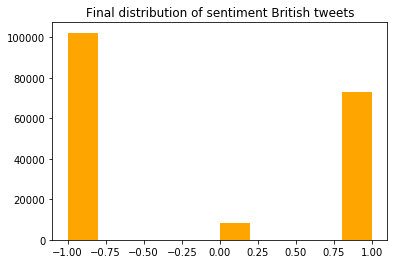

In [49]:
## plotting distribution of sentiment

plt.hist(sentiment, color='orange')
plt.title('Final distribution of sentiment British tweets')

In [50]:
## including the variable in the dataset

final_df['Sentiment'].iloc[:len(sentiment)] = sentiment

C:\Users\emigi\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [51]:
## Removing Nan and saving the file

final_df = final_df.dropna(subset=['Sentiment'])

final_df.to_excel('Final Dataset British Tweets Classified.xlsx')